In [1]:
!jt -l # show available theme

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [2]:
import os
import math

import numpy as np
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from celluloid import Camera

from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.map_expansion import arcline_path_utils

%matplotlib inline
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
jtplot.style(theme='solarizedl', context='notebook', ticks=True, grid=False)
# !jt -l # show available theme

# This is the path where you stored your copy of the nuScenes dataset.
DATAROOT = '/'.join(os.path.abspath(os.curdir).split('/')[:-2])
DATAROOT = os.path.join(DATAROOT, 'data/sets/nuscenes')

nusc = NuScenes('v1.0-mini', dataroot=DATAROOT)
helper = PredictHelper(nusc)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.399 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [3]:
def euler_from_quaternion(w, x, y, z):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
     
        return roll_x, pitch_y, yaw_z # in radians
    

def global_to_local(ego_trans, ego_rot_quaternion, global_locations):
    x,y,z = ego_trans    
    _, _, yaw = euler_from_quaternion(*ego_rot_quaternion)      
    cy = math.cos(yaw) 
    sy = math.sin(yaw)
    
    mat = np.array([[cy, sy, -x*cy - y*sy],
                    [-sy, cy, +x*sy - y*cy],
                    [0, 0, 1]])
    global_locations = global_locations.T 
    
    global_locations = np.vstack([global_locations,                                  
                                  np.ones_like(global_locations[0])])
    local_locations = np.matmul(mat, global_locations)
    return local_locations.T[:,:2]

def local_to_global(ego_trans, ego_rot_quaternion, local_locations):
    x,y,z = ego_trans    
    _, _, yaw = euler_from_quaternion(*ego_rot_quaternion)      
    cy = math.cos(yaw) 
    sy = math.sin(yaw)
    
    mat = np.array([[cy, -sy, x],
                    [sy, cy, y],
                    [0, 0, 1]])
    local_locations = local_locations.T 
    
    local_locations = np.vstack([local_locations,                                  
                                  np.ones_like(local_locations[0])])
    global_locations = np.matmul(mat, local_locations)
    return global_locations.T[:,:2]

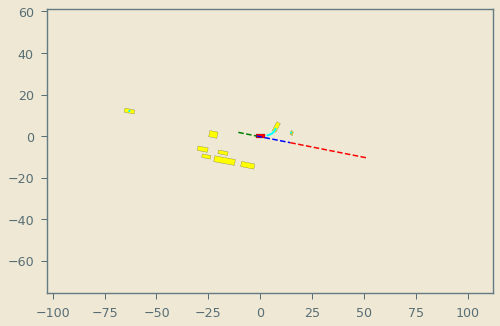

In [7]:
scene_idx = 0
ego_l = 4.6
ego_w = 1.8

plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['axes.grid'] = False

fig = plt.gcf()
camera = Camera(fig)
ax = plt.gca()

current_sample_token = nusc.scene[scene_idx]['first_sample_token']
current_sample = nusc.get('sample', current_sample_token)

while True:        
    ax = plt.gca()
    ax.set_aspect('equal')
    # ax.clear()
    ego_pos = nusc.get('ego_pose', nusc.get('sample_data', current_sample['data']['LIDAR_TOP'])['ego_pose_token'])    
    sample_anns = helper.get_annotations_for_sample(current_sample_token)

    instance_tables = dict()
    for ann in sample_anns:
        if ann['category_name'].startswith('vehicle'): #and int(ann['visibility_token']) > 3 and ann['num_lidar_pts'] > 10:
            instance_tables[ann['instance_token']] = ann

    future_trajectories = dict()
    past_trajectories = dict()
    for instance_token in instance_tables.keys():
        future_trajectory = helper.get_future_for_agent(instance_token, current_sample_token, seconds=3, in_agent_frame=False)    
        if len(future_trajectory) != 0:
            future_trajectories[instance_token] = future_trajectory
        past_trajectory = helper.get_past_for_agent(instance_token, current_sample_token, seconds=3, in_agent_frame=False)        
        if len(past_trajectory) != 0:
            past_trajectories[instance_token] = past_trajectory

    l = ego_l
    w = ego_w
    point = np.array([[l/2,w/2],[-l/2,w/2],[-l/2,-w/2],[l/2,-w/2]])
    rect_ego = patches.Polygon(point, fill=True ,edgecolor='k', facecolor='red', ls='solid')    
    ax.add_patch(rect_ego)

    map_name = nusc.get('log', nusc.get('scene',nusc.get('sample',current_sample_token)['scene_token'])['log_token'])['location']    
    nusc_map = NuScenesMap(map_name=map_name, dataroot=DATAROOT)
    closest_lane = nusc_map.get_closest_lane(ego_pos['translation'][0], ego_pos['translation'][1], radius=2)
    closest_lane_record = nusc_map.get_arcline_path(closest_lane)
    incoming_lanes = nusc_map.get_incoming_lane_ids(closest_lane)
    incoming_lane_records = {lane : nusc_map.get_arcline_path(lane) for lane in incoming_lanes}
    outgoing_lanes = nusc_map.get_outgoing_lane_ids(closest_lane)
    outgoing_lane_records = {lane : nusc_map.get_arcline_path(lane) for lane in outgoing_lanes}

    closest_lane_poses = global_to_local(ego_pos['translation'], ego_pos['rotation'],
                                        np.array(arcline_path_utils.discretize_lane(closest_lane_record, resolution_meters=1))[:,:2])
    incoming_lane_poses = {lane: global_to_local(ego_pos['translation'], ego_pos['rotation'],
                                                 np.array(arcline_path_utils.discretize_lane(lane_record, resolution_meters=1))[:,:2]) 
                           for lane, lane_record in incoming_lane_records.items()}
    outgoing_lane_poses = {lane: global_to_local(ego_pos['translation'], ego_pos['rotation'],
                                                 np.array(arcline_path_utils.discretize_lane(lane_record, resolution_meters=1))[:,:2])
                           for lane, lane_record in outgoing_lane_records.items()}

    ax.plot(closest_lane_poses[:,0], closest_lane_poses[:,1], color='blue', linestyle='dashed')
    for k, v in incoming_lane_poses.items():
        ax.plot(v[:,0], v[:,1], color='green', linestyle='dashed')
    for k, v in outgoing_lane_poses.items():
        ax.plot(v[:,0], v[:,1], color='red', linestyle='dashed')

    for instance_token, ann in instance_tables.items():
        w, l, h = ann['size']                    
        point = np.array([[l/2,w/2],[-l/2,w/2],[-l/2,-w/2],[l/2,-w/2]])
        global_point = local_to_global(ann['translation'], ann['rotation'],point)    
        local_point = global_to_local(ego_pos['translation'], ego_pos['rotation'], global_point)

        # rect = patches.Polygon(global_point, fill=True ,edgecolor='k', facecolor='yellow', ls='solid')    
        # ax.add_patch(rect)        
        rect_others = patches.Polygon(local_point, fill=True ,edgecolor='k', facecolor='yellow', ls='solid')    
        ax.add_patch(rect_others)                                

    for instance_token, future_trajectory in future_trajectories.items():              
        future_trajectory_local = global_to_local(ego_pos['translation'], ego_pos['rotation'], future_trajectory)    
        ax.plot(future_trajectory_local[:,0], future_trajectory_local[:,1], color='purple', linewidth=2) 
    for instance_token, past_trajectory in past_trajectories.items():               
        past_trajectory_local = global_to_local(ego_pos['translation'], ego_pos['rotation'], past_trajectory)    
        ax.plot(past_trajectory_local[:,0], past_trajectory_local[:,1], color='cyan', linewidth=2)     
    
    # ax.axis('equal')
    # plt.gcf().canvas.draw()
    # x_lim = ax.get_xlim()
    # y_lim = ax.get_ylim()
    # ax.set_xlim(int(x_lim[0]), int(x_lim[1]))
    # ax.set_ylim(int(y_lim[0]), int(y_lim[1]))
    # x_lim = ax.get_xlim()
    # y_lim = ax.get_ylim()
    # width = int(x_lim[1] - x_lim[0])
    # height = int(y_lim[1] - y_lim[0])

    # ego_yaw = math.degrees(euler_from_quaternion(*ego_pos['rotation'])[2])
    # layer_names = ['drivable_area']
    # canvas_size = (int(width), int(height))
    # # patch_box=(ego_pos['translation'][0], ego_pos['translation'][1],*canvas_size)
    # patch_box=(ego_pos['translation'][0], ego_pos['translation'][1],*canvas_size)
    # map_mask = nusc_map.get_map_mask(patch_box, ego_yaw, layer_names, canvas_size)
    # plt.imshow(map_mask[0], extent=[*x_lim,*y_lim])            
    
    # plt.show()
    
    camera.snap()    
    if current_sample['next'] == '':
        break
    current_sample_token = current_sample['next']
    current_sample = nusc.get('sample', current_sample['next'])

animation = camera.animate()
animation.save('video_scene_{}.mp4'.format(nusc.scene[scene_idx]['description']))

In [53]:
def rotation(rot, points : np.ndarray):
    points = np.hstack([points,np.zeros_like(points)])
    w,x,y,z = rot
    L_rot_mat = np.array([[w, z, -y, -x],
                          [-z, w, x, -y],
                          [y, -x, w, -z],
                          [x, y, z, w]])
    R_rot_inv_mat = np.array([[w, z, -y, x],
                              [-z, w, x, y],
                              [y, -x, w, z],
                              [-x, -y, -z, w]])
    rot_mat = np.matmul(R_rot_inv_mat, L_rot_mat)
    return np.matmul(points, rot_mat)[:,:2]    

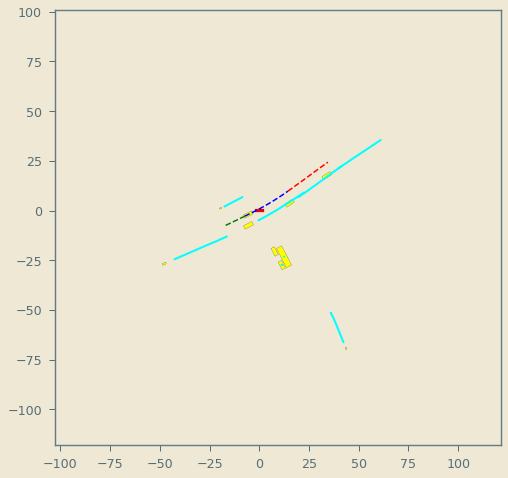

In [90]:
for i in range(len(nusc.scene)):
    scene_idx = i
    ego_l = 4.6
    ego_w = 1.8

    plt.rcParams['figure.figsize'] = (8,8)
    plt.rcParams['axes.grid'] = False

    fig = plt.gcf()
    camera = Camera(fig)
    ax = plt.gca()
    plt.cla()

    current_sample_token = nusc.scene[scene_idx]['first_sample_token']
    current_sample = nusc.get('sample', current_sample_token)

    while True:            
        ego_pos = nusc.get('ego_pose', nusc.get('sample_data', current_sample['data']['LIDAR_TOP'])['ego_pose_token'])    
        sample_anns = helper.get_annotations_for_sample(current_sample_token)

        instance_tables = dict()
        for ann in sample_anns:
            if ann['category_name'].startswith('vehicle'): #and int(ann['visibility_token']) > 3 and ann['num_lidar_pts'] > 10:
                instance_tables[ann['instance_token']] = ann

        future_trajectories = dict()
        past_trajectories = dict()
        for instance_token in instance_tables.keys():
            future_trajectory = helper.get_future_for_agent(instance_token, current_sample_token, seconds=3, in_agent_frame=False)    
            if len(future_trajectory) != 0:
                future_trajectories[instance_token] = future_trajectory
            past_trajectory = helper.get_past_for_agent(instance_token, current_sample_token, seconds=3, in_agent_frame=False)        
            if len(past_trajectory) != 0:
                past_trajectories[instance_token] = past_trajectory

        l = ego_l
        w = ego_w
        point = np.array([[l/2,w/2],[-l/2,w/2],[-l/2,-w/2],[l/2,-w/2]])
        rect_ego = patches.Polygon(point, fill=True ,edgecolor='k', facecolor='red', ls='solid')    
        ax.add_patch(rect_ego)
        w,i,j,k = ego_pos['rotation']
        ego_pos_inv = [w,-i,-j,-k]

        for instance_token, ann in instance_tables.items():
            w, l, h = ann['size']                    
            point = np.array([[l/2,w/2],[-l/2,w/2],[-l/2,-w/2],[l/2,-w/2]])          
            global_point =  rotation(ann['rotation'], point) + np.array(ann['translation'])[:2]        

            local_point = rotation(ego_pos_inv, global_point - np.array(ego_pos['translation'])[:2]) 

            rect_others = patches.Polygon(local_point, fill=True ,edgecolor='k', facecolor='yellow', ls='solid')    
            ax.add_patch(rect_others)

        for instance_token, future_trajectory in future_trajectories.items():              
            future_trajectory_local = rotation(ego_pos_inv, future_trajectory - np.array(ego_pos['translation'])[:2])
            ax.plot(future_trajectory_local[:,0], future_trajectory_local[:,1], color='purple', linewidth=2) 
        for instance_token, past_trajectory in past_trajectories.items():               
            past_trajectory_local = rotation(ego_pos_inv, past_trajectory - np.array(ego_pos['translation'])[:2])
            ax.plot(past_trajectory_local[:,0], past_trajectory_local[:,1], color='cyan', linewidth=2)

        map_name = nusc.get('log', nusc.get('scene',nusc.get('sample',current_sample_token)['scene_token'])['log_token'])['location']    
        nusc_map = NuScenesMap(map_name=map_name, dataroot=DATAROOT)
        closest_lane = nusc_map.get_closest_lane(ego_pos['translation'][0], ego_pos['translation'][1], radius=2)
        closest_lane_record = nusc_map.get_arcline_path(closest_lane)
        incoming_lanes = nusc_map.get_incoming_lane_ids(closest_lane)
        incoming_lane_records = {lane : nusc_map.get_arcline_path(lane) for lane in incoming_lanes}
        outgoing_lanes = nusc_map.get_outgoing_lane_ids(closest_lane)
        outgoing_lane_records = {lane : nusc_map.get_arcline_path(lane) for lane in outgoing_lanes}

        closest_lane_poses = global_to_local(ego_pos['translation'], ego_pos['rotation'],
                                            np.array(arcline_path_utils.discretize_lane(closest_lane_record, resolution_meters=1))[:,:2])
        incoming_lane_poses = {lane: global_to_local(ego_pos['translation'], ego_pos['rotation'],
                                                     np.array(arcline_path_utils.discretize_lane(lane_record, resolution_meters=1))[:,:2]) 
                               for lane, lane_record in incoming_lane_records.items()}
        outgoing_lane_poses = {lane: global_to_local(ego_pos['translation'], ego_pos['rotation'],
                                                     np.array(arcline_path_utils.discretize_lane(lane_record, resolution_meters=1))[:,:2])
                               for lane, lane_record in outgoing_lane_records.items()}

        ax.plot(closest_lane_poses[:,0], closest_lane_poses[:,1], color='blue', linestyle='dashed')
        for k, v in incoming_lane_poses.items():
            ax.plot(v[:,0], v[:,1], color='green', linestyle='dashed')
        for k, v in outgoing_lane_poses.items():
            ax.plot(v[:,0], v[:,1], color='red', linestyle='dashed')

        plt.axis('equal')
        # fig.canvas.draw()
        # x_lim = ax.get_xlim()
        # y_lim = ax.get_ylim()
        # print(x_lim, y_lim)
        # width = int(x_lim[1] - x_lim[0])
        # height = int(y_lim[1] - y_lim[0])

        # ego_yaw = math.degrees(euler_from_quaternion(*ego_pos['rotation'])[2])
        # layer_names = ['drivable_area']
        # canvas_size = (width, height)
        # patch_box=(ego_pos['translation'][0], ego_pos['translation'][1],*canvas_size)
        # map_mask = nusc_map.get_map_mask(patch_box, ego_yaw, layer_names, canvas_size)
        # plt.imshow(map_mask[0], extent=[*x_lim,*y_lim])                

        # plt.show()

        camera.snap()    
        if current_sample['next'] == '':
            break
        current_sample_token = current_sample['next']
        current_sample = nusc.get('sample', current_sample['next'])

    animation = camera.animate()
    animation.save('video_scene_{}.mp4'.format(nusc.scene[scene_idx]['description']))